In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:

class Points:
    def __init__(self, coordinates, label=None):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.label = label
    
    def __lt__(self, other):
        """Define la relación de orden entre dos puntos."""
        return (self.y > other.y) or (self.y == other.y and self.x < other.x)

    def __str__(self):
        return f"{self.label} ({self.x}, {self.y})"
    
def generate_random_points(N, low_value, high_value, integer=True): 
    """Genera N puntos aleatorios en un rango especificado."""
    coordinates = []
    for i in range(N):
        x = int(np.random.uniform(low_value, high_value)) if integer else np.random.uniform(low_value, high_value)
        y = int(np.random.uniform(low_value, high_value)) if integer else np.random.uniform(low_value, high_value)
        label = f"P{i+1}"
        p = Points((x, y), label)
        coordinates.append(p)
    return coordinates

In [33]:
class Segment:
    segment_count = 0 
    def __init__(self, upper, lower):
        """ Crea un segmento ordenando los puntos según la relación de orden. """
        if upper < lower:  # Usamos la relación de orden en Points
            self.upper = upper  # Extremo superior
            self.lower = lower  # Extremo inferior
        else:
            self.upper = lower
            self.lower = upper

        Segment.segment_count += 1
        self.label = f"S{Segment.segment_count}"  # Nombre único del segmento


    def __str__(self):
        """ Representación legible del segmento. """
        return f"{self.label} (Upper: {self.upper.label}, Lower: {self.lower.label})"

    def __lt__(self, other):
        """ Compara segmentos en la línea de barrido. """
        return self.upper < other.upper  # Se usa la relación de orden entre puntos

    def intersecta_con(self, other):
        """ Determina si dos segmentos se cruzan. """
        def ccw(A, B, C):
            """ Función auxiliar para determinar si tres puntos están en orden antihorario. """
            return (C.y - A.y) * (B.x - A.x) > (B.y - A.y) * (C.x - A.x)

        # Se determina si los segmentos se cruzan verificando la orientación de los puntos
        return (ccw(self.upper, other.upper, other.lower) != ccw(self.lower, other.upper, other.lower) and
                ccw(self.upper, self.lower, other.upper) != ccw(self.upper, self.lower, other.lower))

def generate_random_segments(N, low_value, high_value):
    """Genera N segmentos aleatorios."""
    points = generate_random_points(N * 2, low_value, high_value)  # Generamos 2N puntos
    segments = [Segment(points[i], points[i + 1]) for i in range(0, len(points), 2)]
    return segments

def plot_segments(segments):
    """Visualiza los segmentos en un gráfico."""
    plt.figure(figsize=(6, 6))
    for seg in segments:
        plt.plot([seg.upper.x, seg.lower.x], [seg.upper.y, seg.lower.y], marker='o', label=f"{seg.upper.label}-{seg.lower.label}")
        plt.text(seg.upper.x, seg.upper.y, seg.upper.label, fontsize=12, verticalalignment='bottom', horizontalalignment='right')
        plt.text(seg.lower.x, seg.lower.y, seg.lower.label, fontsize=12, verticalalignment='top', horizontalalignment='right')
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Visualización de Segmentos Aleatorios")
    # plt.legend()
    plt.grid()
    plt.show()

In [15]:
class Node:
    def __init__(self, data, left=None, right=None):
        self.data = data
        self.left = left
        self.right = right
    
    def __str__(self):
        return f"Node(data={self.data}, left={self.left}, right={self.right})"
    

In [16]:
def insert(root, node):
    """Inserta un nodo en el árbol respetando la relación de orden definida en Points."""
    if root is None:
        return node  # Se retorna el nuevo nodo
    
    if node.data < root.data:  # Usamos la comparación definida en __lt__
        root.left = insert(root.left, node)
    else:
        root.right = insert(root.right, node)

    return root


def inorder(root):
    """Recorrido inorder del árbol binario."""
    if root is None:
        return []
    return inorder(root.left) + [root.data] + inorder(root.right)


def depth(root):
    if root is None:
        return -1
    else:
        return 1 + max(depth(root.left), depth(root.right))
    
def BBT(sortedArr):
    if not sortedArr:
        return None
    
    mid = int(len(sortedArr)/2)
    newRoot = Node(sortedArr[mid])
    newRoot.left = BBT(sortedArr[:mid])
    newRoot.right = BBT(sortedArr[mid+1:])
    return newRoot


def print_points(points):
    """Imprime un arreglo de puntos."""
    for i in points:
        print(i)



Segment(P1 (10, 50), P2 (20, 30))
Segment(P3 (15, 60), P4 (25, 40))


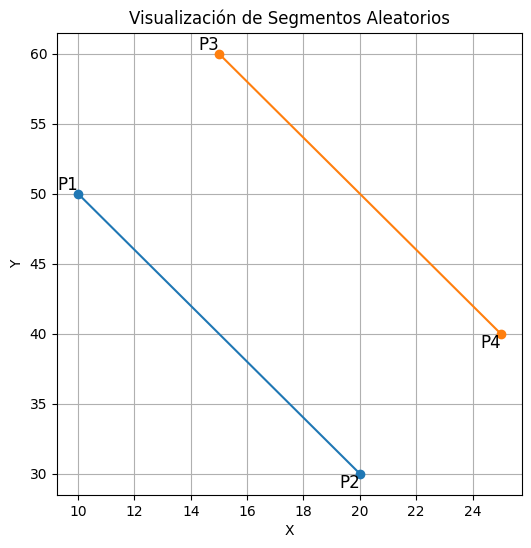

In [ ]:
np.random.seed(20)  # Para reproducibilidad
p1 = Points((10, 50), "P1")
p2 = Points((20, 30), "P2")
p3 = Points((15, 60), "P3")
p4 = Points((25, 40), "P4")

s1 = Segment(p1, p2)
s2 = Segment(p3, p4)

segments = [s1,s2]
print(s1)  # S1 (Upper: P1, Lower: lower)
print(s2)  # S2 (Upper: P3, Lower: P4)
plot_segments(segments)

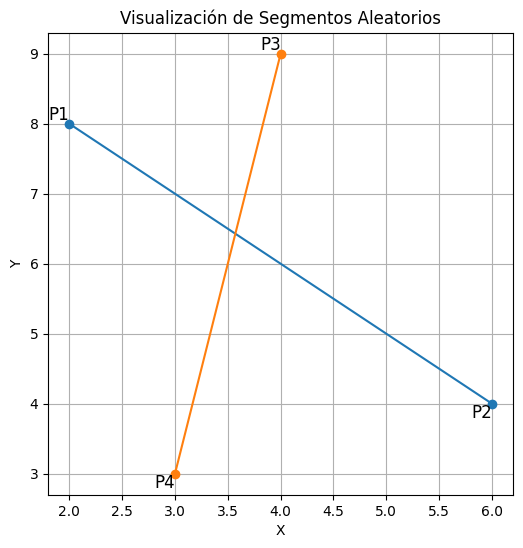

In [26]:
p1 = Points((2, 8), "P1")
p2 = Points((6, 4), "P2")
p3 = Points((4, 9), "P3")
p4 = Points((3, 3), "P4")

s1 = Segment(p1, p2)
s2 = Segment(p3, p4)

segments = [s1,s2]

plot_segments(segments)

In [34]:
class Evento:
    INICIO = "INICIO"
    FIN = "FIN"
    INTERSECCIÓN = "INTERSECCIÓN"

    def __init__(self, punto, tipo, segmentos=None):
        """
        Un evento en la línea de barrido.
        :param punto: Punto donde ocurre el evento.
        :param tipo: Tipo de evento (INICIO, FIN, INTERSECCIÓN).
        :param segmentos: Segmentos involucrados en el evento (lista).
        """
        self.punto = punto
        self.tipo = tipo
        self.segmentos = segmentos if segmentos else []

    def __lt__(self, other):
        """ Ordena los eventos en la lista de eventos. """
        if self.punto.y != other.punto.y:
            return self.punto.y > other.punto.y  # Primero el de mayor Y (barrido descendente)
        return self.punto.x < other.punto.x  # Si Y es igual, menor X primero

    def __str__(self):
        """ Representación legible del evento. """
        segmentos_str = ", ".join([s.label for s in self.segmentos])
        return f"Evento({self.tipo}, Punto={self.punto.label}, Segmentos=[{segmentos_str}])"

def insertar_evento(eventos, nuevo_evento):
    """
    Inserta un evento en la lista ordenada de eventos.
    """
    index = 0
    while index < len(eventos) and eventos[index] < nuevo_evento:
        index += 1
    eventos.insert(index, nuevo_evento)

def generar_eventos(segments):
    """
    Genera la lista de eventos a partir de una lista de segmentos.
    Retorna una lista ordenada de eventos.
    """
    eventos = []
    for seg in segments:
        insertar_evento(eventos, Evento(seg.upper, Evento.INICIO, [seg]))  # Evento de inicio
        insertar_evento(eventos, Evento(seg.lower, Evento.FIN, [seg]))  # Evento de fin
    return eventos


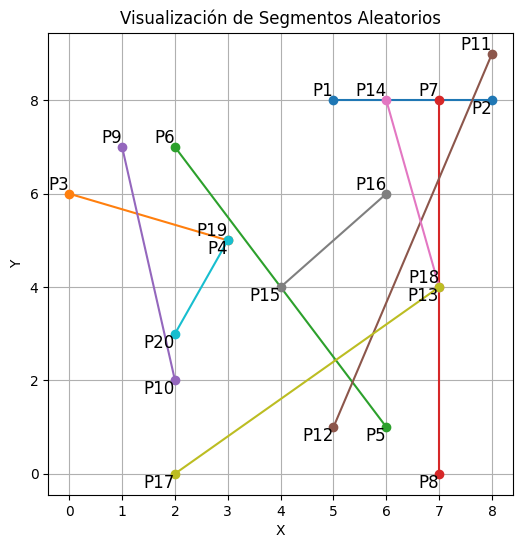

Evento(INICIO, Punto=P11, Segmentos=[S26])
Evento(INICIO, Punto=P1, Segmentos=[S21])
Evento(INICIO, Punto=P14, Segmentos=[S27])
Evento(INICIO, Punto=P7, Segmentos=[S24])
Evento(FIN, Punto=P2, Segmentos=[S21])
Evento(INICIO, Punto=P9, Segmentos=[S25])
Evento(INICIO, Punto=P6, Segmentos=[S23])
Evento(INICIO, Punto=P3, Segmentos=[S22])
Evento(INICIO, Punto=P16, Segmentos=[S28])
Evento(INICIO, Punto=P19, Segmentos=[S30])
Evento(FIN, Punto=P4, Segmentos=[S22])
Evento(FIN, Punto=P15, Segmentos=[S28])
Evento(INICIO, Punto=P18, Segmentos=[S29])
Evento(FIN, Punto=P13, Segmentos=[S27])
Evento(FIN, Punto=P20, Segmentos=[S30])
Evento(FIN, Punto=P10, Segmentos=[S25])
Evento(FIN, Punto=P12, Segmentos=[S26])
Evento(FIN, Punto=P5, Segmentos=[S23])
Evento(FIN, Punto=P17, Segmentos=[S29])
Evento(FIN, Punto=P8, Segmentos=[S24])


In [37]:
np.random.seed(20)  # Para reproducibilidad
segmentos = generate_random_segments(10,0,10)
plot_segments(segmentos)
eventos = generar_eventos(segmentos)
for i in eventos:
    print(i)

In [ ]:
class NodoSegmento:
    def __init__(self, segmento, left=None, right=None):
        self.segmento = segmento
        self.left = left
        self.right = right

class EstadoLineaBarrido:
    def __init__(self):
        self.raiz = None

    def insertar(self, segmento):
        """ Inserta un segmento en el árbol ordenado por X. """
        self.raiz = self._insertar(self.raiz, segmento)
        if self._es_desbalanceado(self.raiz):
            self.reconstruir_arbol()

    def _insertar(self, nodo, segmento):
        if nodo is None:
            return NodoSegmento(segmento)

        if segmento.upper.x < nodo.segmento.upper.x:
            nodo.left = self._insertar(nodo.left, segmento)
        else:
            nodo.right = self._insertar(nodo.right, segmento)

        return nodo

    def eliminar(self, segmento):
        """ Elimina un segmento del árbol. """
        self.raiz = self._eliminar(self.raiz, segmento)
        if self._es_desbalanceado(self.raiz):
            self.reconstruir_arbol()

    def _eliminar(self, nodo, segmento):
        if nodo is None:
            return None

        if segmento.upper.x < nodo.segmento.upper.x:
            nodo.left = self._eliminar(nodo.left, segmento)
        elif segmento.upper.x > nodo.segmento.upper.x:
            nodo.right = self._eliminar(nodo.right, segmento)
        else:
            if nodo.left is None:
                return nodo.right
            if nodo.right is None:
                return nodo.left
            temp = self._encontrar_min(nodo.right)
            nodo.segmento = temp.segmento
            nodo.right = self._eliminar(nodo.right, temp.segmento)

        return nodo

    def _es_desbalanceado(self, nodo):
        """ Verifica si el árbol está desbalanceado. """
        if nodo is None:
            return False
        return abs(self._profundidad(nodo.left) - self._profundidad(nodo.right)) > 1

    def _profundidad(self, nodo):
        """ Calcula la profundidad del árbol. """
        if nodo is None:
            return 0
        return 1 + max(self._profundidad(nodo.left), self._profundidad(nodo.right))

    def reconstruir_arbol(self):
        """ Reconstruye el árbol balanceado si está desbalanceado. """
        segmentos = self.inorder()
        self.raiz = self._balancear(segmentos)

    def inorder(self):
        """ Retorna una lista de segmentos en orden. """
        return self._inorder(self.raiz, [])

    def _inorder(self, nodo, lista):
        if nodo is not None:
            self._inorder(nodo.left, lista)
            lista.append(nodo.segmento)
            self._inorder(nodo.right, lista)
        return lista

    def _balancear(self, segmentos):
        """ Crea un nuevo árbol balanceado a partir de una lista ordenada de segmentos. """
        if not segmentos:
            return None
        mid = len(segmentos) // 2
        nodo = NodoSegmento(segmentos[mid])
        nodo.left = self._balancear(segmentos[:mid])
        nodo.right = self._balancear(segmentos[mid + 1:])
        return nodo

    def obtener_vecinos(self, segmento):
        """ Encuentra los segmentos vecino superior e inferior en el estado. """
        return self._obtener_vecinos(self.raiz, segmento, None, None)

    def _obtener_vecinos(self, nodo, segmento, vecino_superior, vecino_inferior):
        if nodo is None:
            return vecino_superior, vecino_inferior

        if segmento.upper.x < nodo.segmento.upper.x:
            vecino_superior = nodo.segmento
            return self._obtener_vecinos(nodo.left, segmento, vecino_superior, vecino_inferior)
        elif segmento.upper.x > nodo.segmento.upper.x:
            vecino_inferior = nodo.segmento
            return self._obtener_vecinos(nodo.right, segmento, vecino_superior, vecino_inferior)
        else:
            return vecino_superior, vecino_inferior
